# Error propagation with correlation

Checking if the covariance term does matter in the error estimation of the stellar masses of galaxies.

Created by Mária Pálfi (marika97@caesar.elte.hu).

In [1]:
# importing useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
from scipy.optimize import curve_fit
import seaborn as sns
plt.style.use('seaborn-white') # set figure style

## Function for error propagation

We approximate the error with the standard deviation, $\sigma_f$, calculated from 

$$\sigma_f^2 \approx \sum_{i=1}^n \left|\frac{\partial f}{\partial x_i}\right|^2 \sigma_i^2 + 2 \cdot \sum_{j=1}^n \sum_{k>j}^n \frac{\partial f}{\partial x_j} \frac{\partial f}{\partial x_k} \sigma_j \sigma_k \rho_{ij},
$$

where $f$ is a function of $x_i$ variables with $\sigma_i$ uncertainty, $\rho$ is the correlation coefficient of $i$ and $j$ variable.

In [2]:
def error_estimator_var( derivative, var, size, N ):
    summa_var = np.zeros( size )
    for i in range( 0, N ):
        summa_var += derivative[i]**2 * var[i]**2
    return summa_var
        
        
def error_estimator_covar( derivative, var, corr_coef, size, N ):
    summa_covar = np.zeros( size )
    for j in range( 0, N ):
        for k in range( j+1, N ):
            summa_covar += derivative[j] * derivative[k] * var[j] * var[k] * corr_coef[j][k]
    return 2 * summa_covar

### Plotting functions

In [3]:
def comp_hist( rel_err, rel_corr_err ):
    fig, ax = plt.subplots(figsize = (20, 12), dpi = 100)
    plt.xlabel( 'Relative error of stellar mass [%]', fontsize = 40 )
    plt.ylabel( 'Relative frequency [%]', fontsize = 40 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )
    plt.xticks(fontsize = 35 )
    plt.yticks( fontsize = 35 )
    plt.xlim( 0, 200)
    plt.yscale( 'linear' )
    plt.xscale('log')
    plt.autoscale()
    ax.set_xticks(np.arange( 0, 110, 20) )
    ax.set_xticklabels(np.arange(0, 110, 20))

    freq, bins = np.histogram( rel_err*100,  bins=100, density = True )
    plt.plot( bins[:-1], freq*(bins[1]-bins[0])*100, lw = 3, label = 'without correlation', color = 'purple' )

    freq, bins = np.histogram( rel_corr_err*100,  bins=100, density = True )
    plt.plot( bins[:-1], freq*(bins[1]-bins[0])*100, lw = 3, label = 'with correlation', color = 'gold' )
    plt.grid()
    plt.legend(fontsize = 35)

In [4]:
def comp_plot( rel_err, rel_corr_err ):
    # form the figure:
    fig = plt.figure( figsize = (20,12), dpi = 100 )
    plt.xlabel( 'Relative error without correlation [%]', fontsize = 40 )
    plt.ylabel( 'Relative error with correlation [%]', fontsize = 40 )
    plt.xticks( fontsize = 35 )
    plt.yticks( fontsize = 35 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )

    plt.scatter( rel_err, rel_corr_err, s = 0.01, color = 'forestgreen' )

    # draw a 45 degree straight line:
    xval = np.linspace( min(rel_err), max(rel_err), len(rel_err) )
    plt.plot( xval, xval, 'black', lw = 0.5)

    plt.grid()

## Reading the necessary columns

In [5]:
# reading the file to 'data' pandas dataframe
data = pd.read_csv( 'data_for_work.txt', delimiter = '\t', low_memory = False )
print( 'dataframe with the necessary columns:\n' )
data

dataframe with the necessary columns:



,GWGC,Hyp,designation,wiseX,type,ra,dec,W1,W2,z,lumdis,lumdis_err,k_m_ext,k_msig_ext,w1mCorr,w1mCorrErr,w2mCorr,w2mCorrErr,fromAllSky
0,NGC4736,NGC4736,12505314+4107125,NaN,G,192.721451,41.120152,NaN,NaN,0.000991,4.392418,NaN,5.106,0.016,NaN,NaN,NaN,NaN,NaN
1,NGC4548,NGC4548,12352642+1429467,NaN,G,188.860123,14.496320,NaN,NaN,0.004120,15.876007,3.263033,7.115,0.031,NaN,NaN,NaN,NaN,NaN
2,NGC6503,NGC6503,17492651+7008396,NaN,G,267.360474,70.144341,NaN,NaN,0.001000,12.446600,0.987781,7.296,0.021,NaN,NaN,NaN,NaN,NaN
3,NGC4442,NGC4442,12280389+0948130,NaN,G,187.016220,9.803620,NaN,NaN,0.003557,11.461371,2.484465,7.294,0.024,NaN,NaN,NaN,NaN,NaN
4,NGC4469,NGC4469,NaN,NaN,G,187.367000,8.749890,NaN,NaN,0.004139,15.180920,3.321809,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23181753,NaN,NaN,NaN,NaN,Q,359.999118,28.954734,17.728901,16.535843,2.452000,20403.464630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23181754,NaN,NaN,NaN,NaN,Q,359.999303,34.720842,16.933657,15.875454,3.109000,27158.368406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23181755,NaN,NaN,NaN,NaN,Q,359.999615,3.268586,14.833991,13.702355,1.232962,8792.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23181756,NaN,NaN,NaN,NaN,Q,359.999759,20.721079,16.979166,16.091722,2.009865,16022.500633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Filtration

In [6]:
# We need only the galaxies, therefore we filtrate the
# globular clusters ('C') and the quasars ('Q'):
data_new = copy.deepcopy( data[ data.type != 'C' ] )
print('Length without globular clusters:', data_new.shape[0])
data_new = data_new[ data_new.type != 'Q' ]
print('Length with galaxies only:', data_new.shape[0])
#data_new = data_new[ ~np.isnan(data_new.z) ]
#print( 'Length with known redshift:', data_new.shape[0])
# We need the luminosity distance data which are larger than 0:
#print( data_new.type.unique() )
data_new = data_new[ ~np.isnan(data_new.lumdis) ] # we have to have luminosity distance
print( 'Length with known luminosty distance:', data_new.shape[0])

# Then we filtrate out the nan Kmag values, because it is essential 
# to the Cappellari's method (see below), but we save into a 
# new dataframe:
data_new2 = data_new[ ~np.isnan(data_new.k_m_ext) ]
print('Length with Kmag:', data_new2.shape[0])

# We need the WISE magnitude (from the original dataframe):
data_new = data_new[ ~np.isnan(data_new.W1) ]
print('Length with W1:', data_new.shape[0])
data_new = data_new[ ~np.isnan(data_new.W2) ]
print('Length with W2:',data_new.shape[0])
# Cluver's method is valid for galaxies having redshift z < 0.15: 
#data_new = data_new[ data_new.z < 0.15 ]
#print('Length for galaxies with z < 0.15:', data_new.shape[0])

# Let's see how many galaxies have both WISE and Ks magnitudes:
data_new3 = copy.deepcopy( data_new[ ~np.isnan(data_new.k_m_ext) ] )
print('Length with both magnitudes:', data_new3.shape[0])

# Kettlety et al. also filtrated the z < 0.003 galaxies,
# because they may be stellar contamintaion.
print( 'Number of galaxies with z < 0.003:', len( data_new[data_new.z < 0.003 ] ))

Length without globular clusters: 23181758
Length with galaxies only: 22431348
Length with known luminosty distance: 21884622
Length with Kmag: 992764
Length with W1: 20410452
Length with W2: 20410452
Length with both magnitudes: 188607
Number of galaxies with z < 0.003: 2302


## Stellar mass estimation methods

### Cluver's method

According to Cluver et al. 2014 (Cluver, M. E., et al. 2014, The Astrophysical Journal, 782, 90
doi:10.1088/0004-637X/782/2/90), we can estimate the stellar mass with the following equation:

$$lg (M_{stellar} /L_{W1} ) = −1.96(W1 − W2 ) − 0.03,$$ 

where

$$L_{W1} (L_{Sun}) = 10^{−0.4(M −M_{Sun} )},$$  

$$M_{Sun} = 3.24$$ 

$M$ is the absolute magnitude measured in the W1 filter, $W1-W2$ is rest-frame color.

$$M_\ast = 10^{-(1.96+0.4)\cdot(m_\text{W1}+5-5\lg d +2.5854 z)+1.96\cdot(m_\text{W2}+5-5\lg d +2.9358 z )+ 0.4 \cdot 3.24 - 0.03 }.$$

**Partial derivatives:**

$$\frac{\partial M_\ast}{\partial m_{W1}} = -2.36 \cdot M_\ast \cdot \ln|10|,$$

$$\frac{\partial M_\ast}{\partial m_{W2}} = 1.96 \cdot M_\ast \cdot \ln|10|,$$

$$ \frac{\partial M_\ast}{\partial d} =  M_\ast \cdot \ln|10| \cdot \frac{2}{d \cdot \ln(10)} = \frac{2 \cdot M_\ast}{d},$$

$$ \frac{\partial M_\ast}{\partial z} =  M_\ast \cdot \ln|10| \cdot [-2.36 \cdot 2.5854 + 1.96 \cdot 2.9358 ] = -0.3454 \cdot   M_\ast \cdot \ln|10|.$$

**Stellar masses:**

In [7]:
# absolute magnitude in the W1 band without K correction:
M1_wKc = data_new.W1 + 5 - 5 * np.log10( data_new.lumdis*1e6 )
print( 'absolute magnitude in the W1 band without K correction:' )
print( M1_wKc[:5] )

# K corrected absolute W1 magnitudes:
M1 = M1_wKc + 2.5854 * data_new.z 
print( '\nK corrected absolute W1 magnitudes:' )
print( M1[:5] )

# K correction for W1 magnitudes according to Kettlety:
M1_Kettlety = M1_wKc + 7.1 * np.log10(1+data_new.z) 
print( '\nK corrected absolute W1 magnitudes according to Kettlety:' )
print( M1_Kettlety[:5] )


# absolute magnitude in the W2 band without K correction:
M2_wKc = data_new.W2 + 5 - 5 * np.log10( data_new.lumdis*1e6 )
print( '\nabsolute magnitude in the W2 band without K correction:' )
print( M2_wKc[:5] )

# K corrected absolute W2 magnitudes:
M2 = M2_wKc + 2.9358 * data_new.z 
print( '\nK corrected absolute W2 magnitudes:' )
print( M2[:5] )

print('\nLuminosities:')
M_sun = 3.24
L_W1 = 10**( -0.4 * ( M1 - M_sun ) )
print( L_W1[:5] )

print('\nMass-to-light raatio:')
TM = -1.96*( M1 - M2 ) - 0.03
print( TM[:5] )

print( '\nStellar masses:' )
M_Cluver = L_W1 * 10**TM
print( M_Cluver[:5] )

absolute magnitude in the W1 band without K correction:
2015322   -24.277610
2015323   -23.841373
2015324   -25.746217
2015325   -26.053218
2015326   -25.561244
dtype: float64

K corrected absolute W1 magnitudes:
2015322   -23.995998
2015323   -23.643052
2015324   -25.253230
2015325   -25.552411
2015326   -25.148851
dtype: float64

K corrected absolute W1 magnitudes according to Kettlety:
2015322   -23.958807
2015323   -23.613478
2015324   -25.208070
2015325   -25.507247
2015326   -25.104899
dtype: float64

absolute magnitude in the W2 band without K correction:
2015322   -24.550610
2015323   -23.955373
2015324   -26.075217
2015325   -26.464218
2015326   -25.761244
dtype: float64

K corrected absolute W2 magnitudes:
2015322   -24.230831
2015323   -23.730174
2015324   -25.515416
2015325   -25.895536
2015326   -25.292959
dtype: float64

Luminosities:
2015322    7.841498e+10
2015323    5.665273e+10
2015324    2.496274e+11
2015325    3.288247e+11
2015326    2.267464e+11
dtype: float64

Mas

**Error estimation:**

If there is no magnitude error, I use the mean $\Delta m$.

In [8]:
w1err_mean = np.mean(data_new.w1mCorrErr)
w2err_mean = np.mean(data_new.w2mCorrErr)

data_new.w1mCorrErr.fillna(w1err_mean, inplace = True )
data_new.w2mCorrErr.fillna(w2err_mean, inplace = True )

Where do the luminosity distances come from?

In [9]:
GWGC_idx = np.argwhere( data_new.GWGC.values.astype(str) != 'nan' ).flatten()
Hyp_idx = np.argwhere( data_new.Hyp.values.astype(str) != 'nan' ).flatten()
twoMASS_idx = np.argwhere( data_new.designation.values.astype(str) != 'nan' ).flatten()

cat_flag_W = 4*np.ones( len(data_new), dtype = np.int8 )
cat_flag_W[twoMASS_idx] = 3
cat_flag_W[Hyp_idx] = 2
cat_flag_W[GWGC_idx] = 1

data_new['cat_flag'] = cat_flag_W
data_new.head()

,GWGC,Hyp,designation,wiseX,type,ra,dec,W1,W2,z,lumdis,lumdis_err,k_m_ext,k_msig_ext,w1mCorr,w1mCorrErr,w2mCorr,w2mCorrErr,fromAllSky,cat_flag
2015322,NaN,1102028,00005632-0205221,J000056.39-020523.3,G,0.234695,-2.089495,14.308,14.035,0.108924,521.341075,NaN,13.633,0.172,14.308,0.056,14.035,0.067,0.0,2
2015323,NaN,1112296,23591740-0142134,J235917.43-014213.2,G,359.822540,-1.703735,13.936,13.822,0.076708,359.314386,NaN,13.724,0.191,13.936,0.027,13.822,0.042,0.0,2
2015324,NaN,1113689,NaN,J000014.50-013858.7,G,0.060450,-1.649560,14.165,13.836,0.190681,959.938689,NaN,NaN,NaN,14.165,0.027,13.836,0.042,0.0,2
2015325,NaN,NaN,23581606-0137396,J235816.01-013739.3,G,359.566925,-1.627676,13.896,13.485,0.193706,976.885557,NaN,13.293,0.203,13.896,0.027,13.485,0.035,0.0,3
2015326,NaN,1113236,23575503-0140058,J235755.05-014005.8,G,359.479309,-1.668278,13.922,13.722,0.159509,788.222607,NaN,13.887,0.235,13.922,0.027,13.722,0.038,0.0,2


Number of galaxies in the different catalogs:

In [10]:
(cat_flag_W == 1).sum(), (cat_flag_W == 2).sum(), (cat_flag_W == 3).sum(), (cat_flag_W == 4).sum()

(11073, 897394, 44017, 19457968)

Luminosity distance errors in the different catalogs:

In [11]:
lumdis_err = np.zeros( len(data_new) )

lumdis_err[cat_flag_W == 1] = 0.2 * data_new.lumdis[cat_flag_W == 1]
lumdis_err[cat_flag_W == 2] = 0.36 * data_new.lumdis[cat_flag_W == 2]
lumdis_err[cat_flag_W == 3] = 0.15 * data_new.lumdis[cat_flag_W == 3]
lumdis_err[cat_flag_W == 4] = 0.011 * data_new.lumdis[cat_flag_W == 4]

data_new['lumdis_err'] = lumdis_err

Redshift errors in the different catalogs:

In [12]:
z_err = np.zeros( len(data_new) )

z_err[cat_flag_W == 1] = 0.19 * data_new.z[cat_flag_W == 1]
z_err[cat_flag_W == 2] = 0.36 * data_new.z[cat_flag_W == 2]
z_err[cat_flag_W == 3] = 0.15 * data_new.z[cat_flag_W == 3]
z_err[cat_flag_W == 4] = 0.033 * data_new.z[cat_flag_W == 4]

data_new['z_err'] = z_err

The terms in the error propagation:

In [13]:
log = np.log(10)*M_Cluver

Cluver_der_W1 = -2.36*log
Cluver_der_W2 = 1.96*log
Cluver_der_d = 2*M_Cluver/data_new.lumdis
Cluver_der_z = -0.345416*log

Cluver_der = [ Cluver_der_W1, Cluver_der_W2, Cluver_der_d, Cluver_der_z ]
Cluver_var = [(data_new.w1mCorrErr), (data_new.w2mCorrErr), (data_new.lumdis_err), (data_new.z_err)]
Cluver_var_err = error_estimator_var( Cluver_der, Cluver_var, len(data_new), 4 )

Correlation coefficients:

In [14]:
corr_coef_W1 = [data_new.W1.corr(data_new.W1), data_new.W1.corr(data_new.W2),
                data_new.W1.corr(data_new.lumdis), data_new.W1.corr(data_new.z)]
corr_coef_W2 = [data_new.W2.corr(data_new.W1), data_new.W2.corr(data_new.W2),
                data_new.W2.corr(data_new.lumdis), data_new.W2.corr(data_new.z)]
corr_coef_d = [data_new.lumdis.corr(data_new.W1), data_new.lumdis.corr(data_new.W2),
                data_new.lumdis.corr(data_new.lumdis), data_new.lumdis.corr(data_new.z)]

Cluver_corr_coef = [ corr_coef_W1, corr_coef_W2, corr_coef_d ]

In [15]:
Cluver_covar_err = error_estimator_covar(Cluver_der, Cluver_var, Cluver_corr_coef, len(data_new), 4 )

rel_err_M_Cluver = np.sqrt(Cluver_var_err)/M_Cluver
rel_corr_err_M_Cluver = np.sqrt(Cluver_var_err + Cluver_covar_err)/M_Cluver

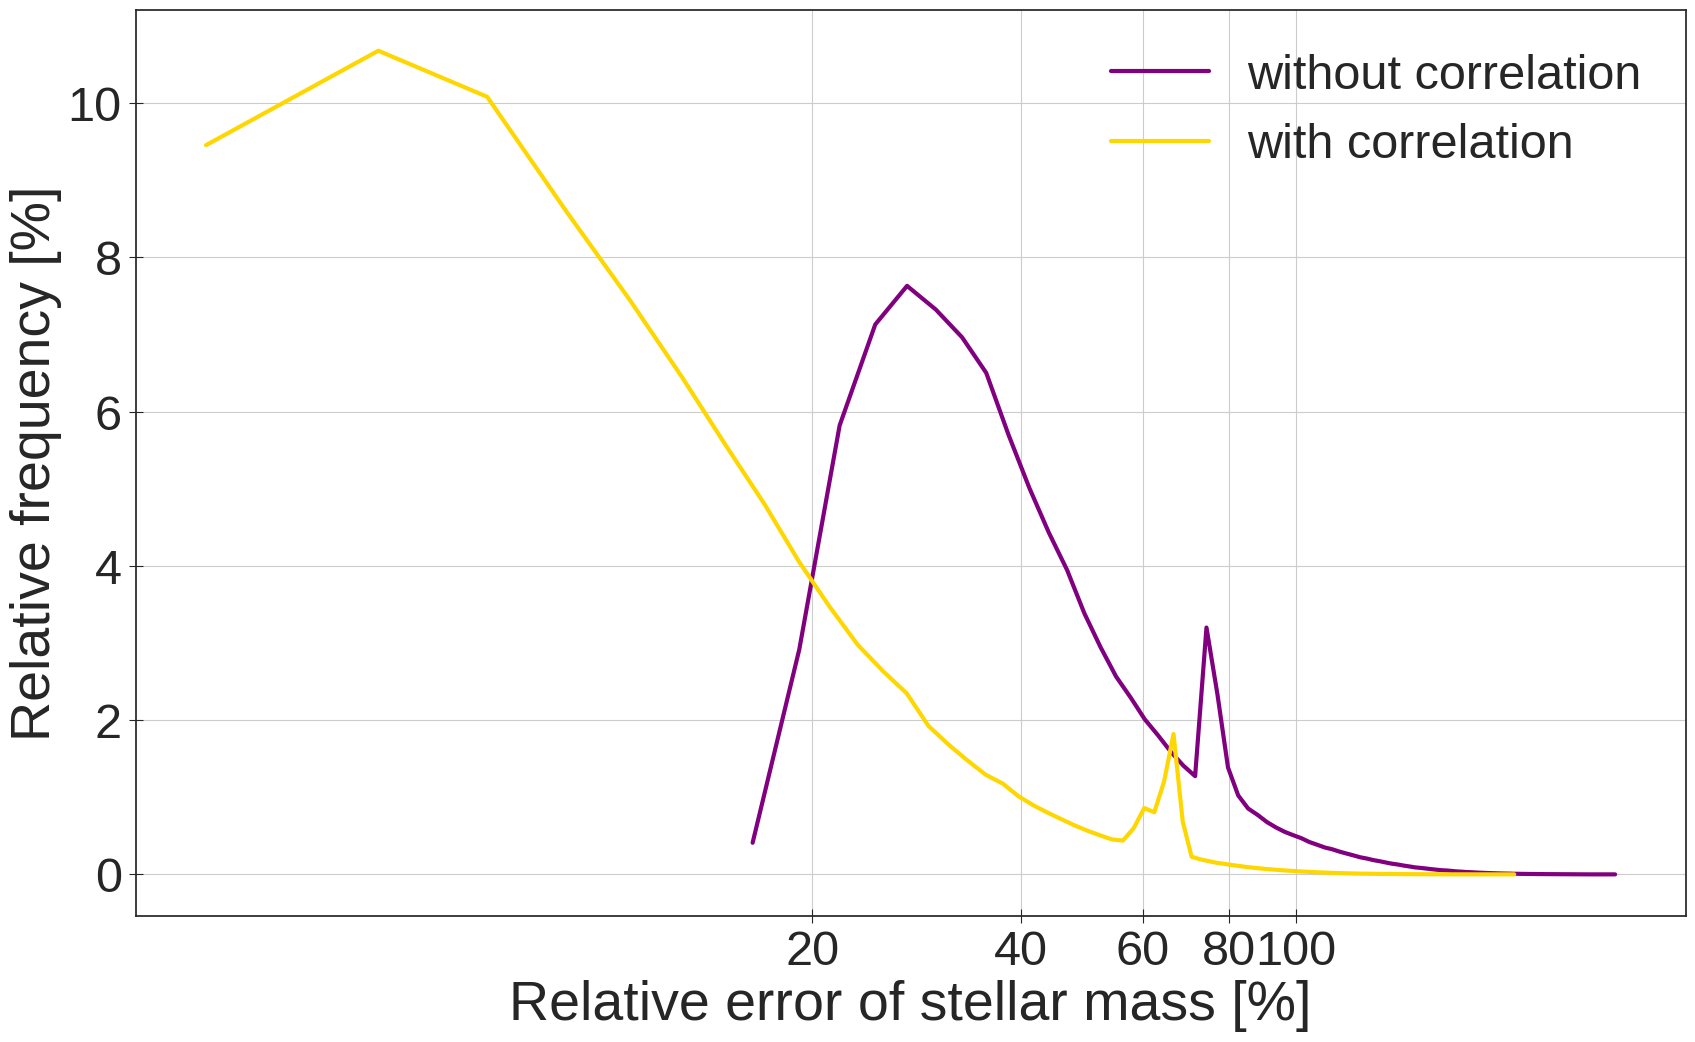

In [16]:
comp_hist( rel_err_M_Cluver, rel_corr_err_M_Cluver )

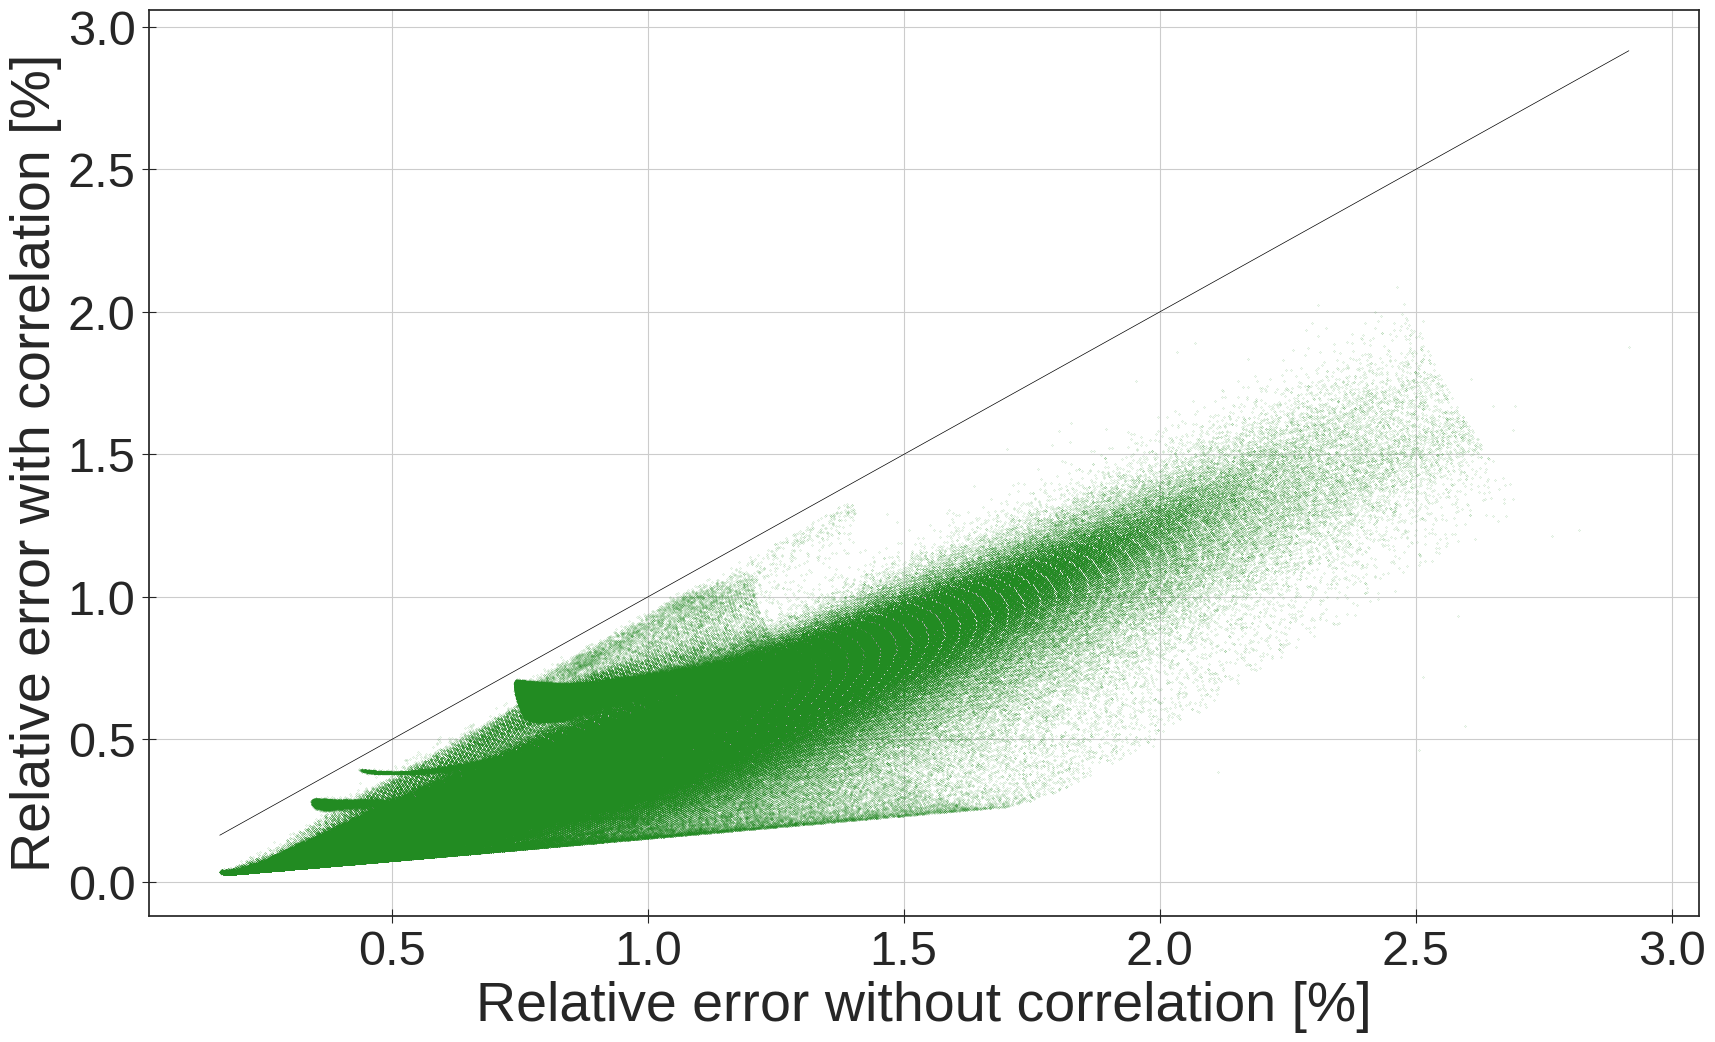

In [17]:
comp_plot( rel_err_M_Cluver, rel_corr_err_M_Cluver )

### Jarrett's method

Jarrett et al. 2013, AJ, 145, 6 (doi:10.1088/0004-6256/145/1/6)

$$\log(M_\ast (K_s )/L_{W1} )(M_\odot /L_\odot )
= −0.246(\pm0.027) − 2.100(\pm0.238)(W1 − W2),$$

$$M_\ast(a,b,m_\text{W1},m_\text{W2},d,z) = 10^{a+(b-0.4)\cdot (m_\text{W1}+5-5 \lg d + 2.5854 z)-b \cdot (m_\text{W2}+5-5\lg d +2.9358 z)-0.4 \cdot 3.24},$$

where $a=-0.25$, $b = -2.1$, $\Delta a = 0.03$ and $\Delta b = 0.2$.

**Partial derivatives:**

$$\frac{\partial M_\ast}{\partial a} = M_\ast \cdot \ln|10|,$$

$$\frac{\partial M_\ast}{\partial b} = M_\ast \cdot \ln|10| \cdot [m_\text{W1}+5-5 \lg d + 2,5854 z - (m_\text{W2}+5-5\lg d +2,9358 z)] =  M_\ast \cdot \ln|10| \cdot (W1-W2),$$

$$\frac{\partial M_\ast}{\partial m_{W1}} = M_\ast \cdot \ln|10| \cdot (b-0.4) = -2.5 \cdot M_\ast \cdot \ln|10|,$$

$$\frac{\partial M_\ast}{\partial m_{W2}} = M_\ast \cdot \ln|10| \cdot (-b) = 2.1 \cdot M_\ast \cdot \ln|10|,$$

$$ \frac{\partial M_\ast}{\partial d} =  M_\ast \cdot \ln|10| \cdot \frac{2}{d \cdot \ln(10)} = \frac{2 \cdot M_\ast}{d},$$

$$ \frac{\partial M_\ast}{\partial z} =  M_\ast \cdot \ln|10| \cdot [(b-0.5) \cdot 2.5854 - b \cdot 2.9358 ] = -0.5569 \cdot   M_\ast \cdot \ln|10|.$$

**Stellar masses:**

In [18]:
# mass-to-light ratio
mtl = -0.25 - 2.1 *( M1 - M2 ) 
print( 'mass-to-light ratios:' )
print( mtl[:5] )

# stellar masses according to Jarrett et al.:
M_Jarrett = L_W1*10**(mtl) 
print( '\nstellar masses according to Jarrett et al.:' )
print( M_Jarrett[:5] )

mass-to-light ratios:
2015322   -0.743149
2015323   -0.432955
2015324   -0.800589
2015325   -0.970563
2015326   -0.552627
dtype: float64

stellar masses according to Jarrett et al.:
2015322    1.416608e+10
2015323    2.090575e+10
2015324    3.950963e+10
2015325    3.518852e+10
2015326    6.352040e+10
dtype: float64


**Error estimation:**

The terms in the error propagation:

In [19]:
log = np.log(10)*M_Jarrett

Jarrett_der_a = log
Jarrett_der_b = (M1 - M2) * log
Jarrett_der_W1 = -2.5 * log
Jarrett_der_W2 = 2.1 * log
Jarrett_der_d = 2*M_Jarrett/data_new.lumdis
Jarrett_der_z = -0.5569 * log

Jarrett_der = [ Jarrett_der_a, Jarrett_der_b, Jarrett_der_W1, Jarrett_der_W2, Jarrett_der_d, Jarrett_der_z ]
Jarrett_var = [ 0.03, 0.2, (data_new.w1mCorrErr), (data_new.w2mCorrErr), (data_new.lumdis_err), (data_new.z_err)]
Jarrett_var_err = error_estimator_var( Jarrett_der, Jarrett_var, len(data_new), 6 )

Correlation coefficients:

$a$ and $b$ do not correlate with the other terms, therefore we have the same correlation coefficients as in the case of Cluver's method.

In [20]:
Jarrett_covar_err = error_estimator_covar(Jarrett_der[2:], Cluver_var, Cluver_corr_coef, len(data_new), 4 )

rel_err_M_Jarrett = np.sqrt(Jarrett_var_err)/M_Jarrett
rel_corr_err_M_Jarrett = np.sqrt(Jarrett_var_err + Jarrett_covar_err)/M_Jarrett

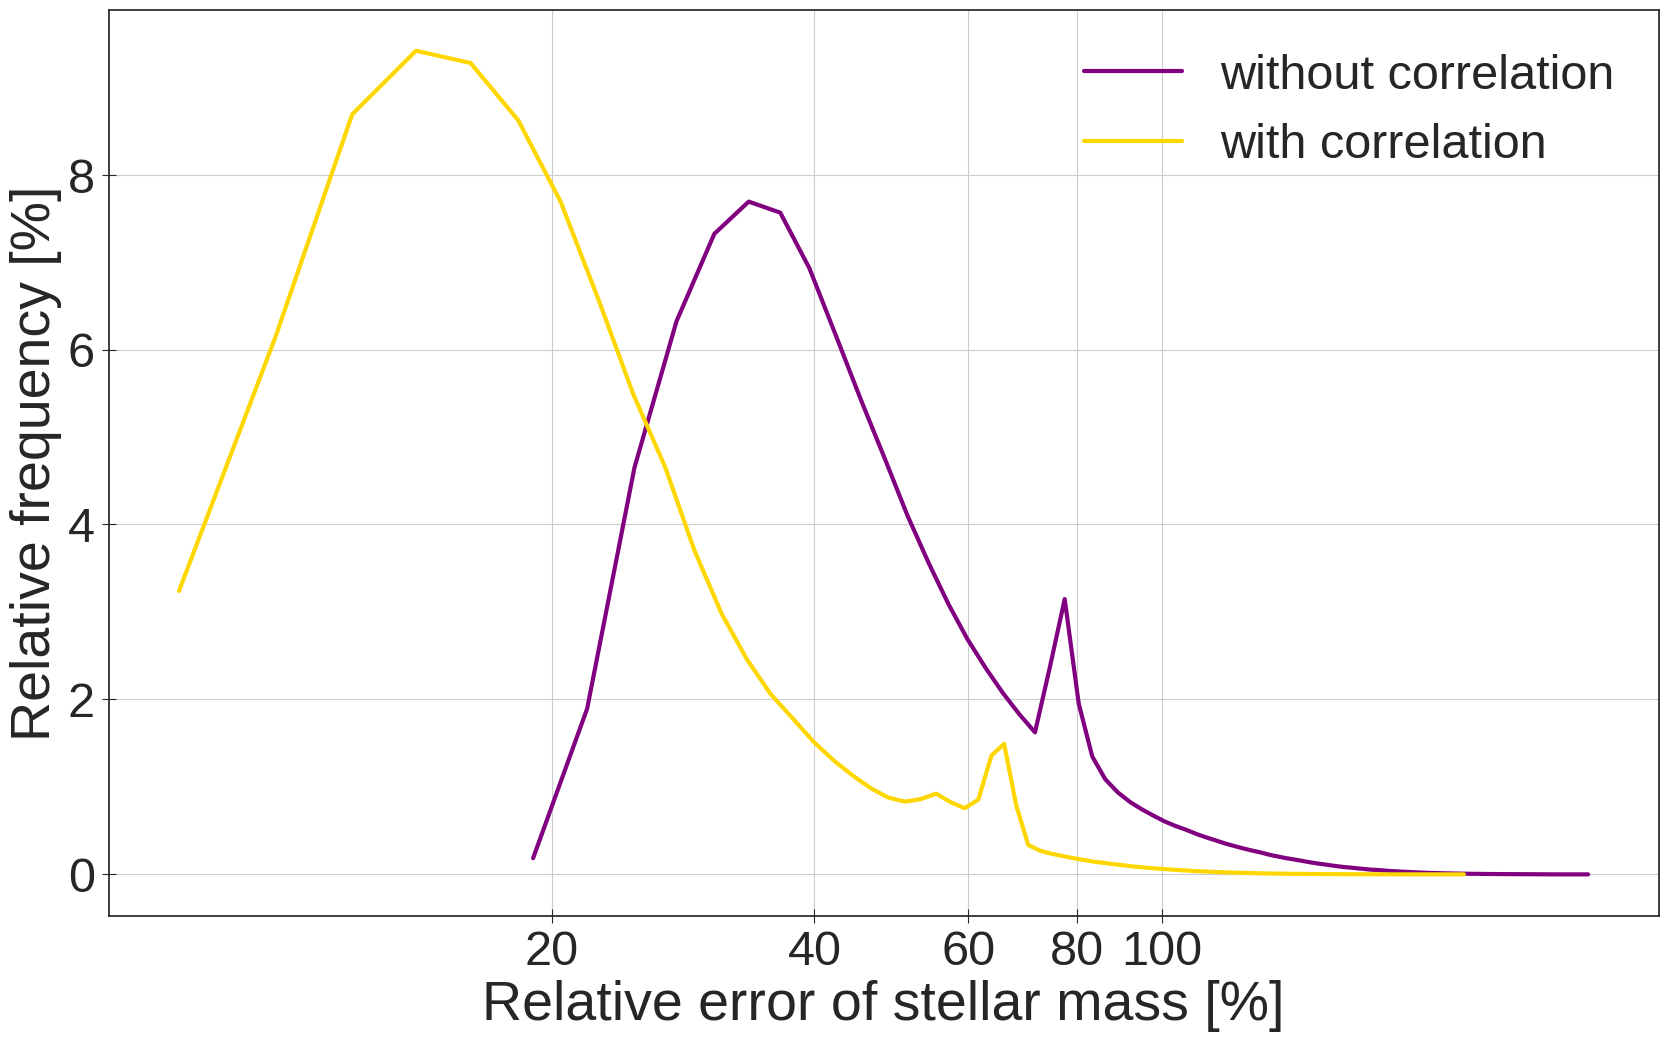

In [21]:
comp_hist( rel_err_M_Jarrett, rel_corr_err_M_Jarrett )

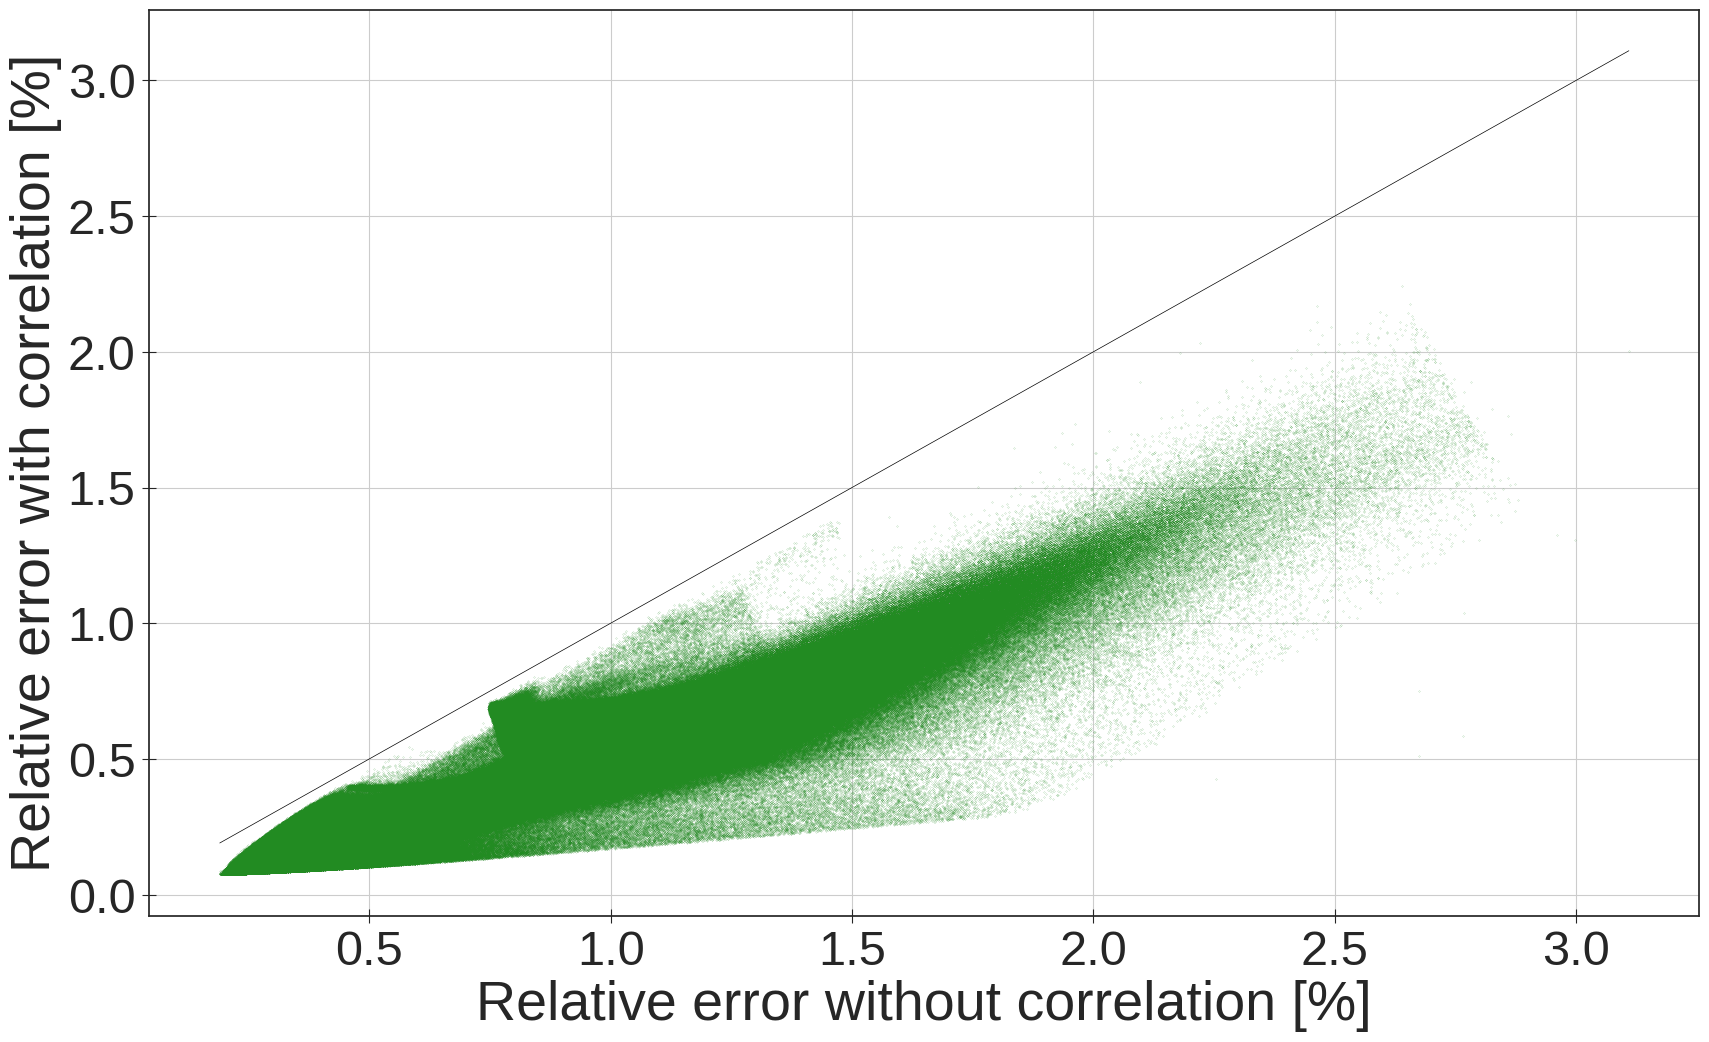

In [22]:
comp_plot( rel_err_M_Jarrett, rel_corr_err_M_Jarrett )

### Kettlety's method

Kettlety et al. 2018. (MNRAS 473, 776–783 (2018), doi:10.1093/mnras/stx2379)

for passive galaxies

$$M_*/L_{W1} = 0.65 \pm 0.07$$

$$M_* = 0.65 \cdot L_{W1}$$

This is best for z $\leq$ 0.15.

(It was first published in Norris et al. (2014) (Norris M. A., Meidt S., van de Ven G., Schinnerer E, Groves B., Querejeta M., 2014, ApJ, 797, 55).)

The stellar mass can be calculated from the WISE W1 magnitude (m) as:

$$M_* = a \cdot 10^{-0.4[m+5-5\lg d + 7.1\lg(1+z)-3.24]},$$

where $a = 0.65$ and $\Delta a = 0.07$.

**Partial derivatives:**

$$\frac{\partial M_\ast}{\partial a} = \frac{M_\ast}{a} = \frac{M_\ast}{0.65},$$

$$\frac{\partial M_\ast}{\partial m} = -0.4 \cdot M_\ast \cdot \ln|10| $$

$$ \frac{\partial M_\ast}{\partial d} =  M_\ast \cdot \ln|10| \cdot \frac{2}{d \cdot \ln(10)} = \frac{2 \cdot M_\ast}{d},$$

$$ \frac{\partial M_\ast}{\partial z} =  M_\ast \cdot \ln|10| \cdot (7.1 -0.4) \cdot \frac{1}{(1+z)\cdot \ln(10)} = \frac{2.84 \cdot M_\ast}{(1+z)}. $$

**Stellar masses:**

In [23]:
M_sun = 3.24

print( '$L_{W1}$ luminosity:' )
L_W1_Kettlety = 10**( -0.4 * ( M1_Kettlety - M_sun ) )
print( L_W1_Kettlety[:5] )

print( '\nThe stellar mass:' )
M_Kettlety = 0.65*L_W1_Kettlety
M_Kettlety[:5]

$L_{W1}$ luminosity:
2015322    7.577446e+10
2015323    5.513039e+10
2015324    2.394572e+11
2015325    3.154270e+11
2015326    2.177508e+11
dtype: float64

The stellar mass:


2015322    4.925340e+10
2015323    3.583475e+10
2015324    1.556472e+11
2015325    2.050275e+11
2015326    1.415380e+11
dtype: float64

**Error estimation:**

The terms in the error propagation:

In [24]:
log = np.log(10)*M_Kettlety

Kettlety_der_a = M_Kettlety/0.65
Kettlety_der_m = -0.4 * log
Kettlety_der_d = 2*M_Kettlety/data_new.lumdis
Kettlety_der_z = -2.84*M_Kettlety/(1+data_new.z)

Kettlety_der = [ Kettlety_der_a, Kettlety_der_m, Kettlety_der_d, Kettlety_der_z ]
Kettlety_var = [ 0.07,(data_new.w1mCorrErr), (data_new.lumdis_err), (data_new.z_err)]
Kettlety_var_err = error_estimator_var( Kettlety_der, Kettlety_var, len(data_new), 4 )

Correlation coefficients:

$a$ does not correlate with the other terms.

We do not need the correlation coefficients with the W2 term.

In [25]:
corr_coef_m = [data_new.W1.corr(data_new.W1), 
                data_new.W1.corr(data_new.lumdis), data_new.W1.corr(data_new.z)]
corr_coef_d = [data_new.lumdis.corr(data_new.W1), 
                data_new.lumdis.corr(data_new.lumdis), data_new.lumdis.corr(data_new.z)]

Kettlety_corr_coef = [ corr_coef_m, corr_coef_d ]

In [26]:
Kettlety_covar_err = error_estimator_covar(Kettlety_der[1:], Kettlety_var[1:], Kettlety_corr_coef,
                                           len(data_new), 3)

Kettlety_err = np.sqrt(Kettlety_var_err)
Kettlety_err_corr = np.sqrt(Kettlety_var_err + Kettlety_covar_err)

rel_err_M_Kettlety = Kettlety_err/M_Kettlety
rel_corr_err_M_Kettlety = Kettlety_err_corr/M_Kettlety

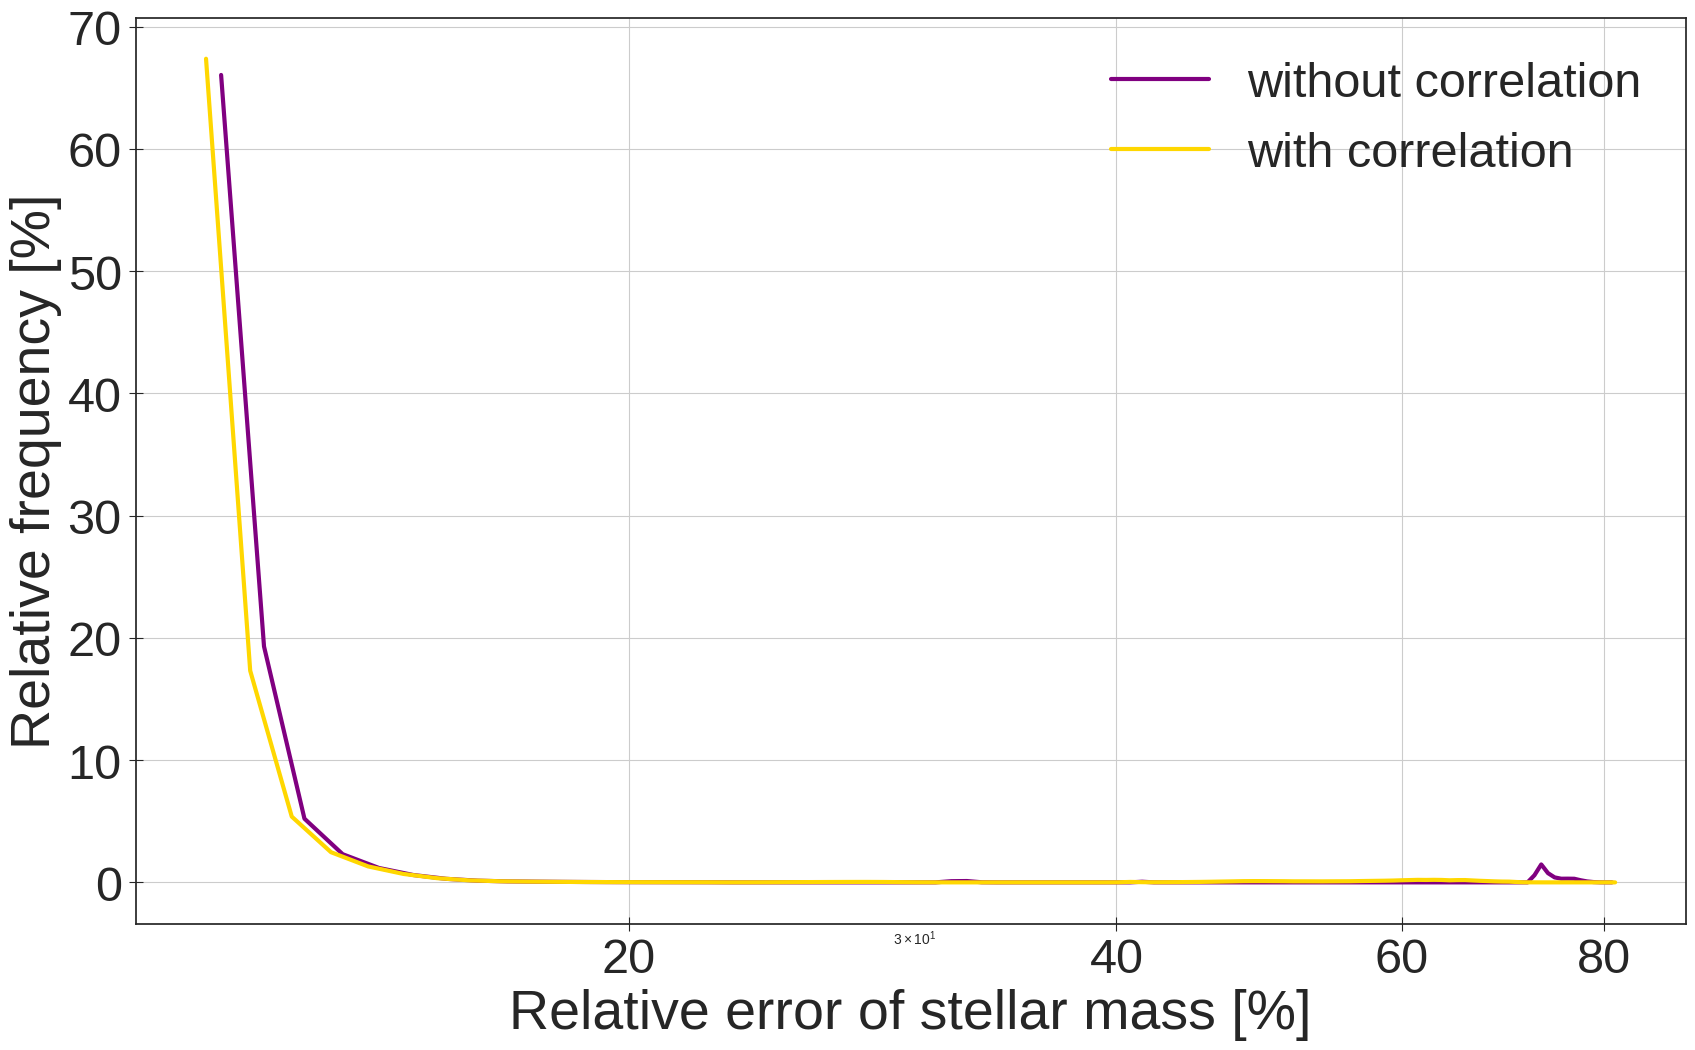

In [27]:
comp_hist( rel_err_M_Kettlety, rel_corr_err_M_Kettlety )

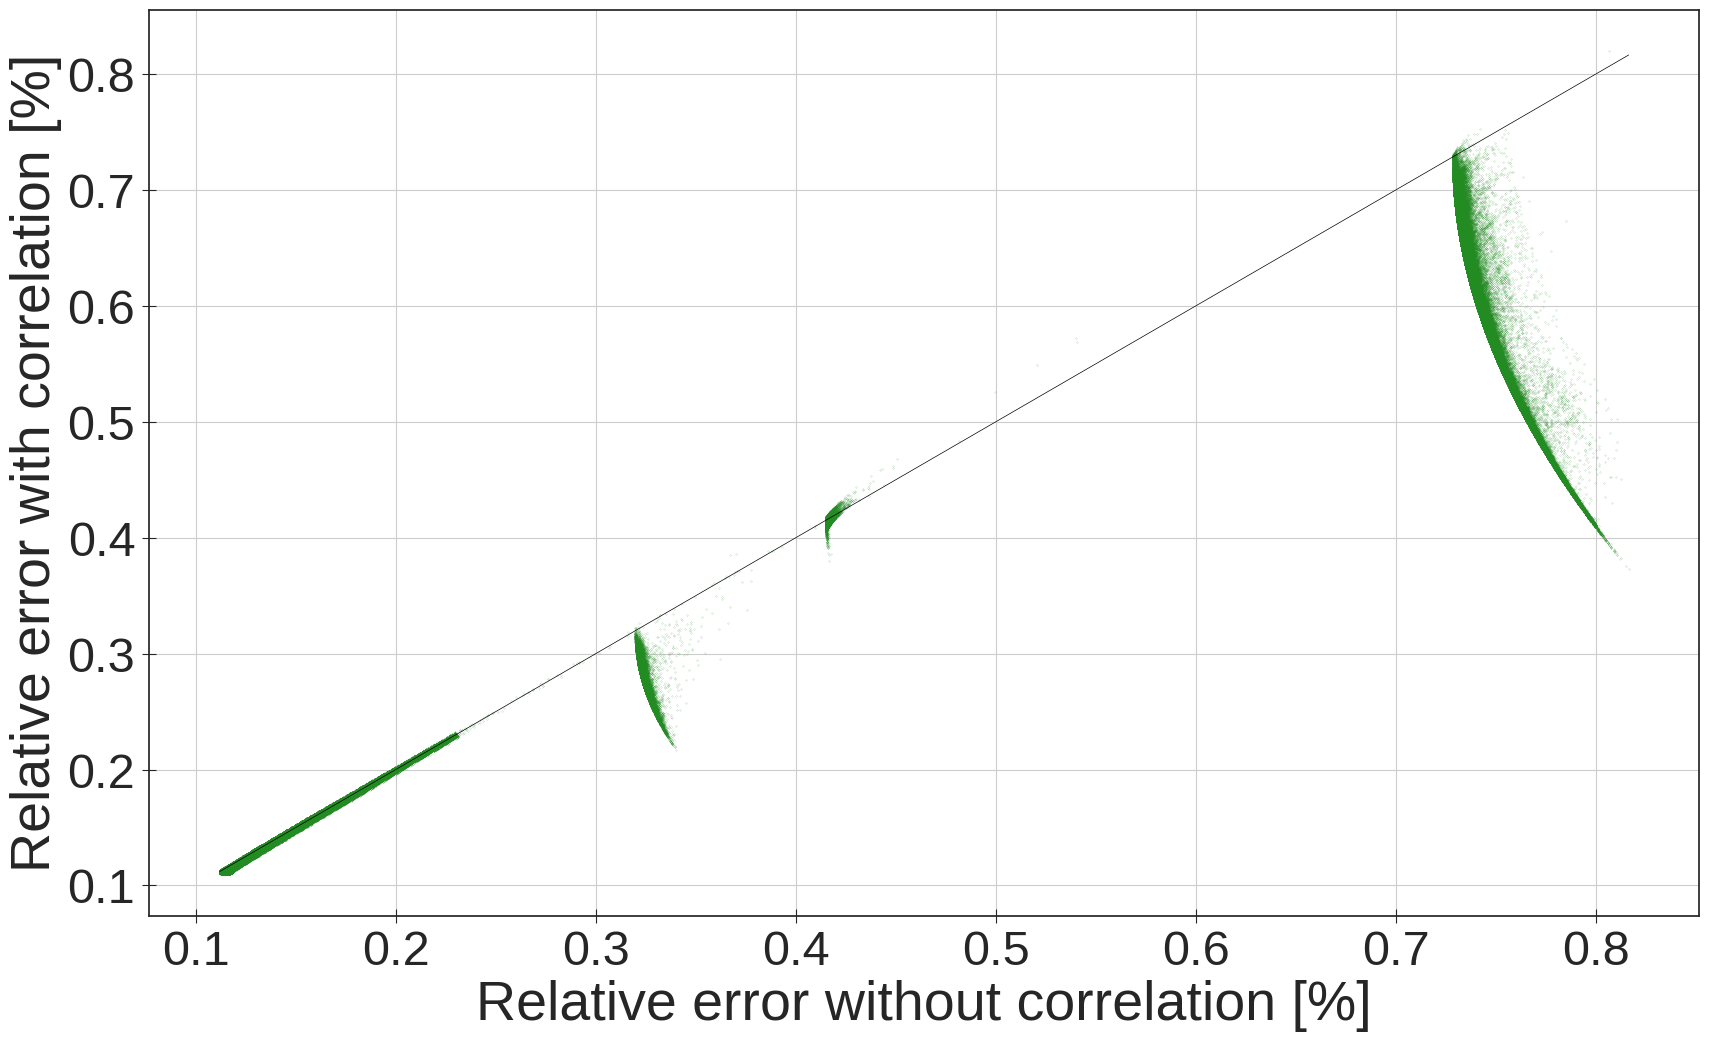

In [28]:
comp_plot( rel_err_M_Kettlety, rel_corr_err_M_Kettlety )

**Rounding the errors:**

In [29]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

# finding the order of the errors:
order_of_err_var = np.array([ orderOfMagnitude(i) for i in Kettlety_err ])
order_of_err_covar = np.array([orderOfMagnitude(i) for i in Kettlety_err_corr ])

# Rounding:
var_err_round = np.array( np.round( Kettlety_err / 10**order_of_err_var ) ) 
covar_err_round = np.array( np.round( Kettlety_err_corr / 10**order_of_err_covar ) ) 

print( (order_of_err_var - order_of_err_covar  == -1).sum(), 
       (order_of_err_var - order_of_err_covar  == 0).sum(),
       (order_of_err_var - order_of_err_covar  == 1).sum() )
print( ( order_of_err_var - order_of_err_covar != 0 ).sum()*100 / len(order_of_err_covar) )

823 20019733 389896
1.914308414139971


The 1.9143% of the errors differs in magnitudes.

In [30]:
diff = np.abs( var_err_round*10**order_of_err_var-covar_err_round*10**order_of_err_covar )
uniq = np.unique( diff )

number = np.zeros(len(uniq))
for i in range( len( uniq ) ):
    number[i] = ( ( diff == uniq[i]).sum() )

In [31]:
number[uniq == 0]/len(M_Kettlety)*100

array([88.64365179])

The 88.6437% of the errors does not differ.

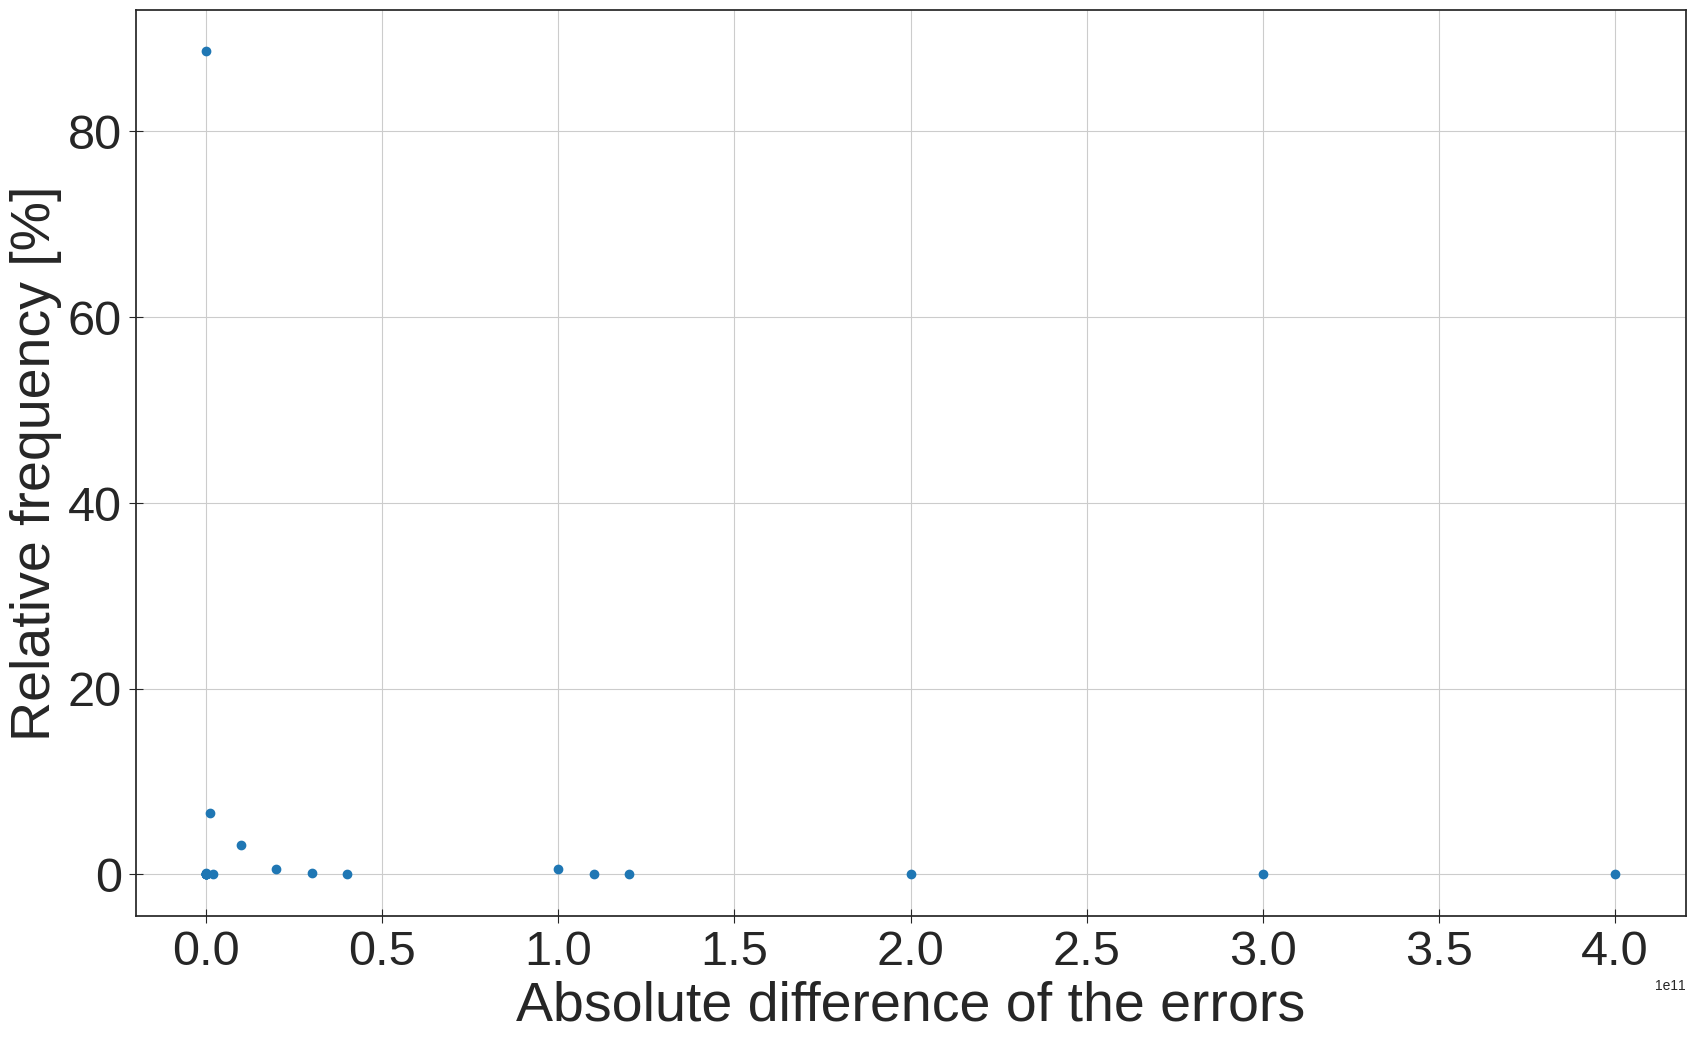

In [46]:
fig, ax = plt.subplots(figsize = (20, 12), dpi = 100)
plt.xlabel( 'Absolute difference of the errors', fontsize = 40 )
plt.ylabel( 'Relative frequency [%]', fontsize = 40 )
plt.tick_params( length=10, direction = 'inout', pad = 5 )
plt.xticks(fontsize = 35 )
plt.yticks( fontsize = 35 )
plt.scatter( uniq, number*100 / len(M_Kettlety) )
plt.grid()

### Cappellari's method

Cappellari 2013. (ApJL 778 L2, 2013, doi:10.1088/2041-8205/778/1/L2)

$$\lg M_∗ ≈ 10.58 − 0.44 (M_{K_s} + 23),$$

where $M_{K_s}$ is the absolute magnitude, but we have the apparent magnitude ($m$), so:

$$M_{K_s} = m+5-5 \lg d.$$


$$ M_* = 10^{a-b\cdot(m+5\lg d -25 -0.11 \cdot A_V + 1.8178\cdot z+23)},$$
where $a=10.583$, $\Delta a = 0.009$, $b=0.445$ and $\Delta b =0.009$.

**Partial derivatives:**

$$\frac{\partial M_\ast}{\partial a} = M_\ast \cdot \ln|10|,$$

$$\frac{\partial M_\ast}{\partial b} = [-(M_K+23)] \cdot \ln|10| \cdot M_\ast,$$

$$\frac{\partial M_\ast}{\partial m} = -b \cdot M_\ast \cdot \ln|10| = -0.445  \cdot M_\ast \cdot \ln|10|,$$

$$ \frac{\partial M_\ast}{\partial d} =  M_\ast \cdot \ln|10| \cdot \frac{-5b}{d \cdot \ln(10)} = \frac{5b \cdot M_\ast}{d} = \frac{2.225 \cdot M_\ast}{d},$$

$$ \frac{\partial M_\ast}{\partial z} = -1.8178 b \cdot M_\ast \cdot \ln|10| = -0.808921  \cdot M_\ast \cdot \ln|10|. $$

**Stellar masses:**

Query extinctions from the dustmap of Schlegel, Finkbeiner & Davis (1998)

In [33]:
%%time
from __future__ import print_function
from astropy.coordinates import SkyCoord
from dustmaps.sfd import SFDQuery

# filter out galaxies which does not have a counterpart in the 2MASS
filt = data_new2.designation.notnull() == True
glade_2MASS = data_new2[filt]

ra = glade_2MASS['ra']
dec = glade_2MASS['dec']

coords = SkyCoord(ra, dec, unit='deg', frame='icrs')

sfd = SFDQuery()
ebv = sfd(coords)

CPU times: user 26.2 s, sys: 331 ms, total: 26.5 s
Wall time: 26.5 s


In order to convert SFD values of E(B-V) to extinction, one should use the conversions provided in Table 6 of Schlafly
& Finkbeiner (2011).


According to Chung-Pei Ma, Jenny E. Greene, Nicholas McConnell, Ryan Janish, John P. Blakeslee, Jens Tho-
mas, and Jeremy D. Murphy. THE MASSIVE SURVEY. i. a VOLUME-LIMITED INTEGRAL-
FIELD SPECTROSCOPIC STUDY OF THE MOST MASSIVE EARLY-TYPE GALAXIES
WITHIN 108 mpc. The Astrophysical Journal, 795(2):158, oct 2014.:

"We compute the absolute K-band magnitudes using
$$M_K = K − 5 \lg D − 25 − 0.11 A_V,$$
where $K$ is given by k_m_ext, and $D$ is the distance in Mpc described in Sec 2.2. We use galactic extinction $A_V$ (Landolt V) from Schlafly & Finkbeiner (2011) and the reddening relation of Fitzpatrick (1999) with $R_V = A_V/E_{B−V} = 3.1$. The values of $K$, $A_V$, and $M_K$ for all galaxies are listed in Table 3. These K−band magnitudes
form the basis for our selection and are used to estimate stellar masses (§ 3.1)."


In Table 6 of Schlafly & Finkbeiner (2011) there is 2.742 in the row of Landolt V and in the column where $R_V$ is 3.1. So I will calculate the extinction as 
$$A_V = 2.742 \cdot E_{B-V},$$
here $E_{B-V}$ is ebv.

In [34]:
ext = 2.742 * ebv 
glade_2MASS['ext'] = ext

In [35]:
print( 'Absolute K_s magnitudes with extinction:' )
abs_m_Ks_E = glade_2MASS.k_m_ext - 5*np.log10(glade_2MASS.lumdis) - 25 - 0.11 * ext + 1.8178 * glade_2MASS.z
print( abs_m_Ks_E[:5] )

print( '\nFiltration:  M_K_s < -21.5 mag')
glade_2MASS = glade_2MASS[abs_m_Ks_E < -21.5]
abs_m_Ks_E = abs_m_Ks_E[abs_m_Ks_E < -21.5]
print( abs_m_Ks_E[:5] )

print( '\nStellar masses from K_s magnitudes:')
M_Cappellari= 10**( 10.58 - 0.44 * (abs_m_Ks_E + 23) )
print( M_Cappellari[:5] )

Absolute K_s magnitudes with extinction:
0   -23.111081
1   -23.892704
2   -23.187067
3   -23.002352
5   -21.684772
dtype: float64

Filtration:  M_K_s < -21.5 mag
0   -23.111081
1   -23.892704
2   -23.187067
3   -23.002352
5   -21.684772
dtype: float64

Stellar masses from K_s magnitudes:
0    4.254765e+10
1    9.392690e+10
2    4.595255e+10
3    3.810964e+10
5    1.002997e+10
dtype: float64


If there is no magnitude error, I use the mean $\Delta m$.

In [36]:
glade_2MASS.k_msig_ext = glade_2MASS.k_msig_ext.fillna(np.mean(glade_2MASS.k_msig_ext))

Where do the luminosity distances come from?

In [37]:
GWGC_idx = np.argwhere( glade_2MASS.GWGC.values.astype(str) != 'nan' ).flatten()
Hyp_idx = np.argwhere( glade_2MASS.Hyp.values.astype(str) != 'nan' ).flatten()
twoMASS_idx = np.argwhere( glade_2MASS.designation.values.astype(str) != 'nan' ).flatten()

cat_flag_K = np.zeros( len(glade_2MASS), dtype = np.int8 )
cat_flag_K[twoMASS_idx] = 3
cat_flag_K[Hyp_idx] = 2
cat_flag_K[GWGC_idx] = 1

glade_2MASS['cat_flag'] = cat_flag_K
glade_2MASS.head()

,GWGC,Hyp,designation,wiseX,type,ra,dec,W1,W2,z,...,lumdis_err,k_m_ext,k_msig_ext,w1mCorr,w1mCorrErr,w2mCorr,w2mCorrErr,fromAllSky,ext,cat_flag
0,NGC4736,NGC4736,12505314+4107125,NaN,G,192.721451,41.120152,NaN,NaN,0.000991,...,NaN,5.106,0.016,NaN,NaN,NaN,NaN,NaN,0.048756,1
1,NGC4548,NGC4548,12352642+1429467,NaN,G,188.860123,14.496320,NaN,NaN,0.004120,...,3.263033,7.115,0.031,NaN,NaN,NaN,NaN,NaN,0.104424,1
2,NGC6503,NGC6503,17492651+7008396,NaN,G,267.360474,70.144341,NaN,NaN,0.001000,...,0.987781,7.296,0.021,NaN,NaN,NaN,NaN,NaN,0.087555,1
3,NGC4442,NGC4442,12280389+0948130,NaN,G,187.016220,9.803620,NaN,NaN,0.003557,...,2.484465,7.294,0.024,NaN,NaN,NaN,NaN,NaN,0.060315,1
5,NGC4586,NGC4586,12382843+0419087,NaN,G,189.618484,4.319099,NaN,NaN,0.003320,...,1.756102,8.468,0.033,NaN,NaN,NaN,NaN,NaN,0.100030,1


Number of galaxies in the different catalogs:

In [38]:
(cat_flag_K==1).sum(), (cat_flag_K==2).sum(), (cat_flag_K==3).sum(), (cat_flag_W==4).sum()

(21990, 584750, 372781, 19457968)

Luminosity distance errors in the different catalogs:

In [39]:
lumdis_err = np.zeros( len(glade_2MASS) )

lumdis_err[cat_flag_K == 1] = 0.2 * glade_2MASS.lumdis[cat_flag_K == 1]
lumdis_err[cat_flag_K == 2] = 0.36 * glade_2MASS.lumdis[cat_flag_K == 2]
lumdis_err[cat_flag_K == 3] = 0.15 * glade_2MASS.lumdis[cat_flag_K == 3]
lumdis_err[cat_flag_K == 4] = 0.011 * glade_2MASS.lumdis[cat_flag_K == 4]

glade_2MASS['lumdis_err'] = lumdis_err

In [40]:
z_err = np.zeros( len(glade_2MASS) )

z_err[cat_flag_K == 1] = 0.19 * glade_2MASS.z[cat_flag_K == 1]
z_err[cat_flag_K == 2] = 0.36 * glade_2MASS.z[cat_flag_K == 2]
z_err[cat_flag_K == 3] = 0.15 * glade_2MASS.z[cat_flag_K == 3]
z_err[cat_flag_K == 4] = 0.033 * glade_2MASS.z[cat_flag_K == 4]

glade_2MASS['z_err'] = z_err

The terms in the error propagation:

In [41]:
log = np.log(10)*M_Cappellari

Cappellari_der_a = log
Cappellari_der_b = -( abs_m_Ks_E + 23 )* log
Cappellari_der_m = -0.445 * log
Cappellari_der_d = 2.225 * M_Cappellari / glade_2MASS.lumdis
Cappellari_der_z = -0.808921 * log

Cappellari_der = [Cappellari_der_a, Cappellari_der_b, Cappellari_der_m, Cappellari_der_d, Cappellari_der_z]
Cappellari_var = [ 0.009, 0.009, (glade_2MASS.k_msig_ext), (glade_2MASS.lumdis_err), (glade_2MASS.z_err)]
Cappellari_var_err = error_estimator_var( Cappellari_der, Cappellari_var, len(glade_2MASS), 5 )

Correlation coefficients:

$a$ and $b$ do not correlate with the other terms.

In [42]:
corr_coef_m = [glade_2MASS.k_m_ext.corr(glade_2MASS.k_m_ext), 
                glade_2MASS.k_m_ext.corr(glade_2MASS.lumdis), glade_2MASS.k_m_ext.corr(glade_2MASS.z)]
corr_coef_d = [glade_2MASS.lumdis.corr(glade_2MASS.k_m_ext), 
                glade_2MASS.lumdis.corr(glade_2MASS.lumdis), glade_2MASS.lumdis.corr(glade_2MASS.z)]

Cappellari_corr_coef = [ corr_coef_m, corr_coef_d ]

In [43]:
Cappellari_covar_err = error_estimator_covar(Cappellari_der[2:], Cappellari_var[2:], Cappellari_corr_coef,
                                           len(glade_2MASS), 3)

rel_err_M_Cappellari = np.sqrt(Cappellari_var_err)/M_Cappellari
rel_corr_err_M_Cappellari = np.sqrt(Cappellari_var_err + Cappellari_covar_err)/M_Cappellari

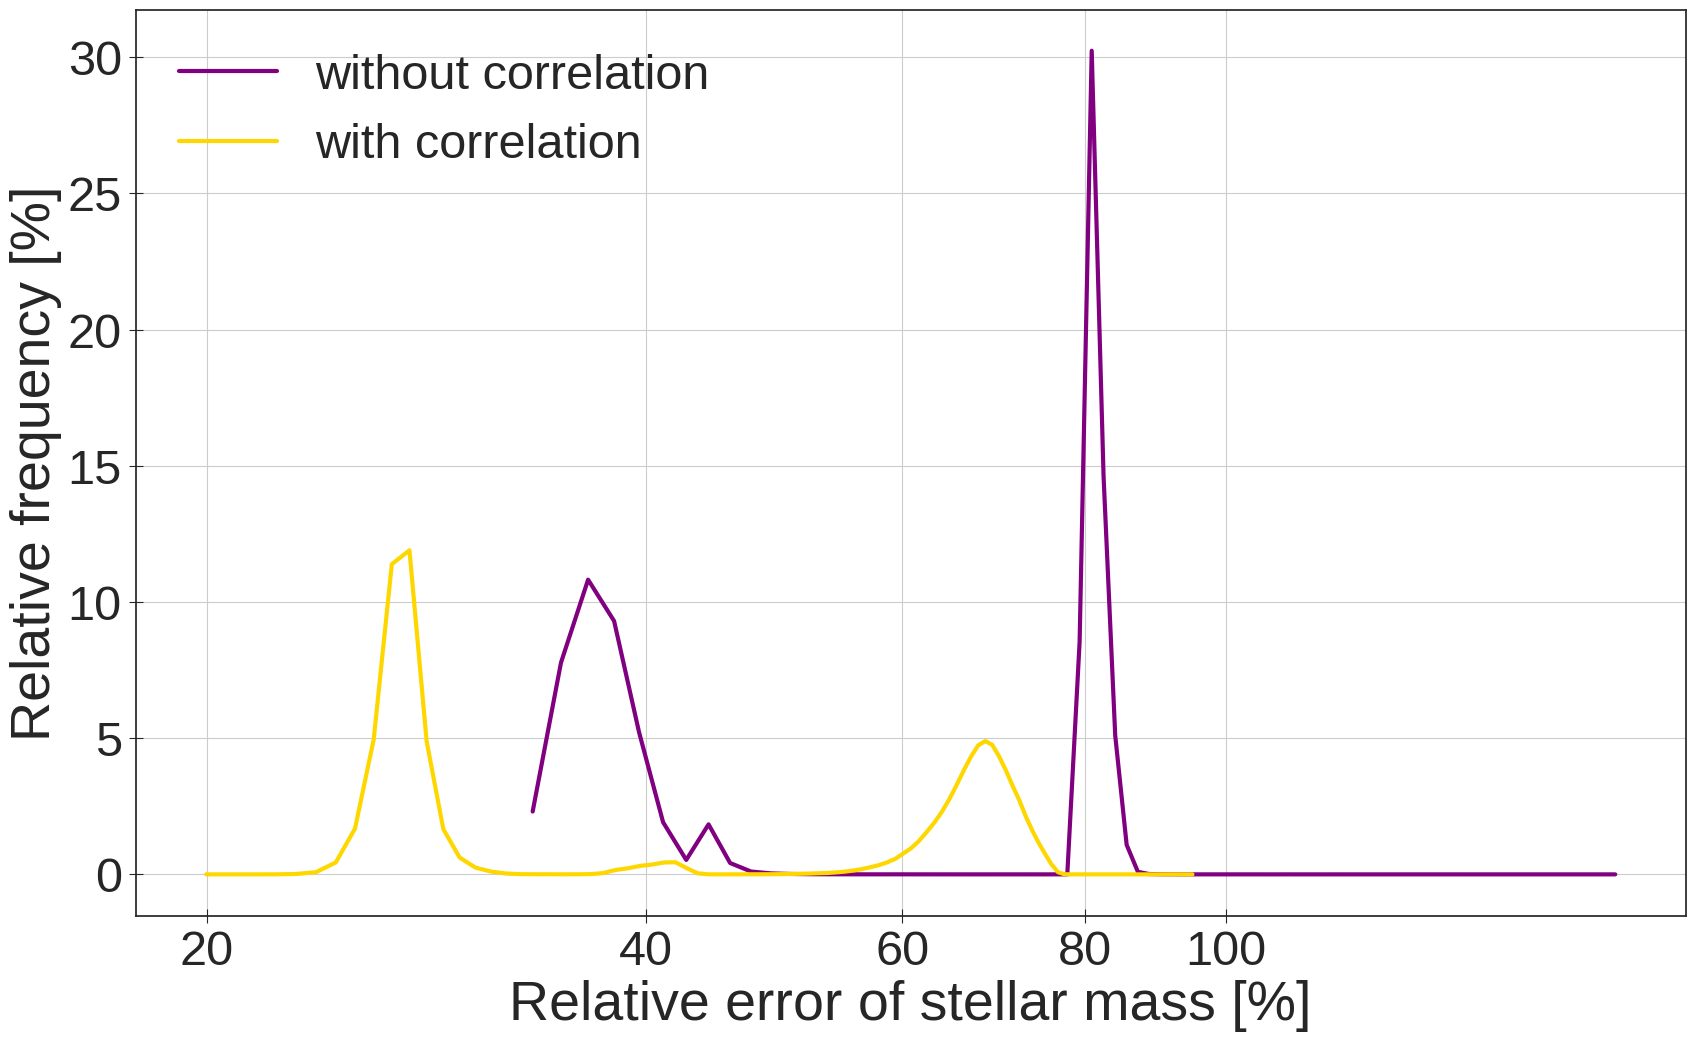

In [44]:
comp_hist( rel_err_M_Cappellari, rel_corr_err_M_Cappellari )

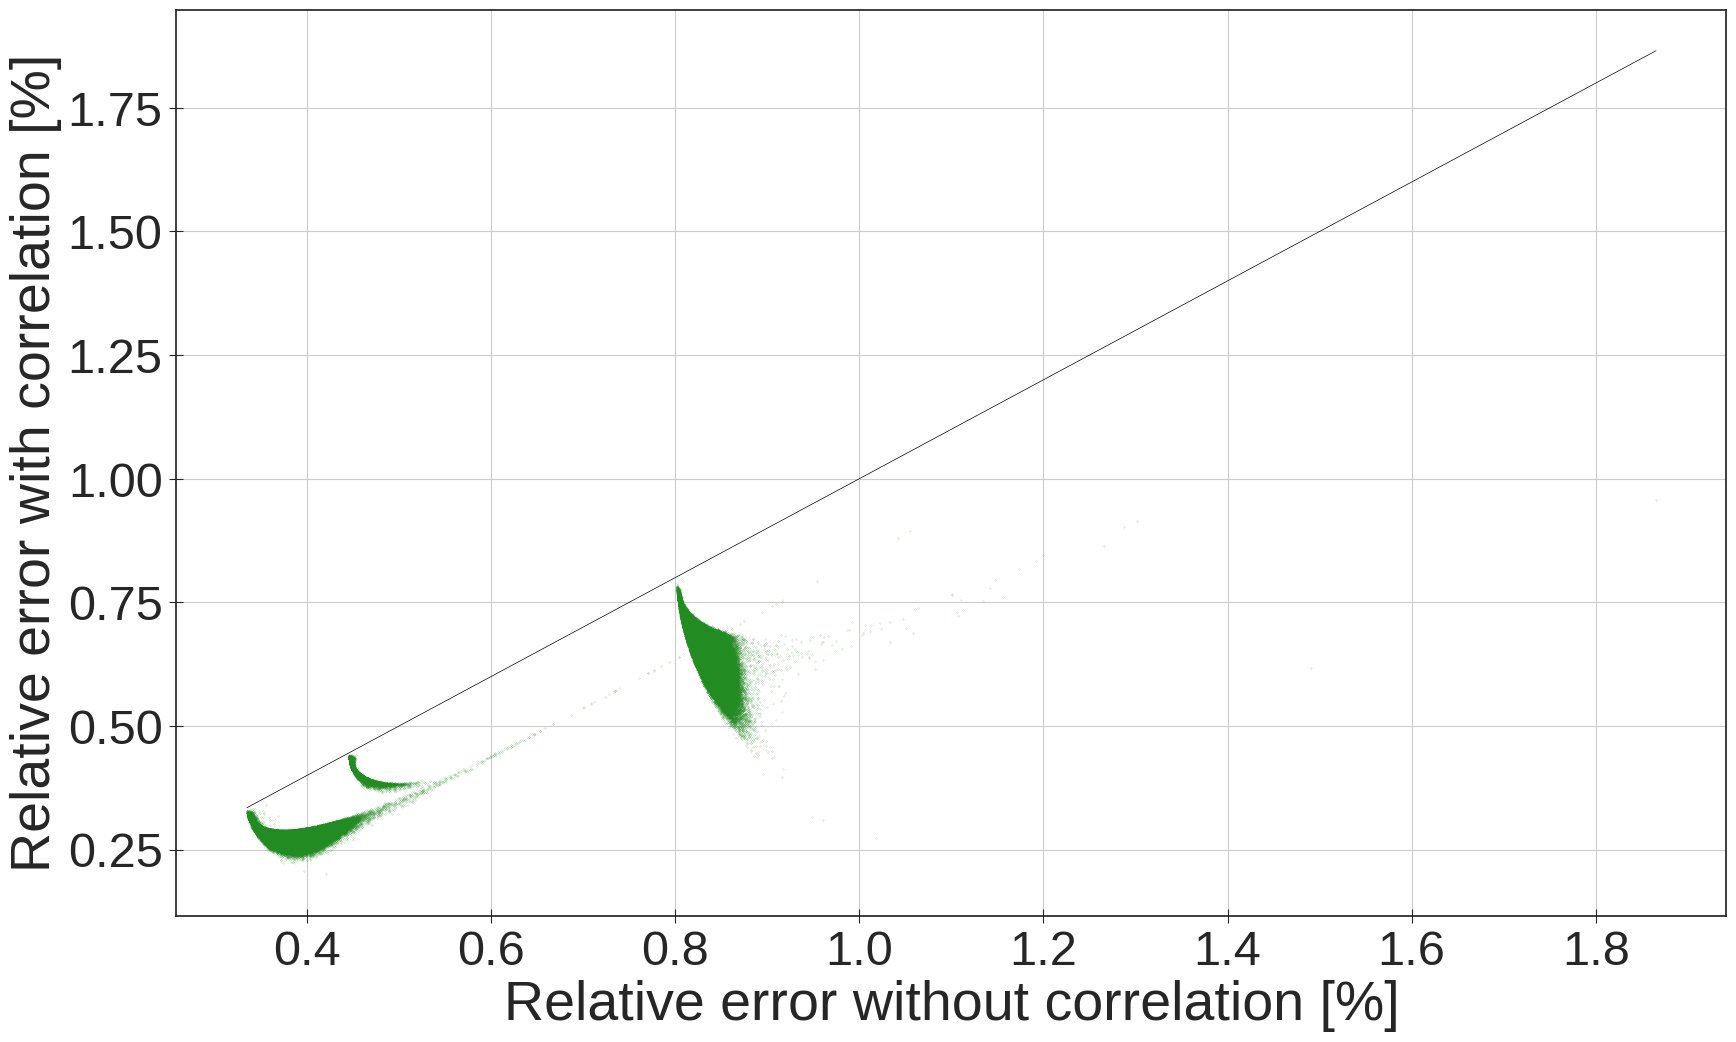

In [45]:
comp_plot( rel_err_M_Cappellari, rel_corr_err_M_Cappellari )